In [1]:
!nvidia-smi

Fri Oct  2 14:47:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/TrafficSignals
!ls

Mounted at /content/drive
/content/drive/My Drive/TrafficSignals
20.jpg					  stop.jpg
carretera_señales.jpg			  x_test.npy
danger.jpg				  x_train.npy
detectTrafficSignals.h5			  yolov3.weights
detectTrafficSignals.ipynb		  y_test.npy
identTrafficSignals_batch50_VGG19_def.h5  y_train.npy
identTrafficSignals.ipynb		  zebra.jpg


(19604, 32, 32, 3)
(19604,)
(12630, 32, 32, 3)
(12630,)


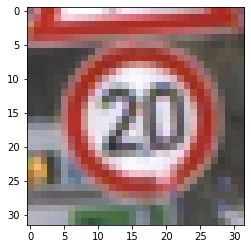

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
gaussian_noise_32 (GaussianN (None, 32, 32, 64)        0         
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
gaussian_noise_33 (GaussianN (None, 32, 32, 64)       

In [5]:
from __future__ import print_function
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

batch_size = 50
num_classes = 43
epochs = 150


#### LOAD AND TRANSFORM

# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_train /= 255
x_test /= 255

# View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### DATA AUGMENTATION
datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rotation_range=20,
            zoom_range=[1.0,1.2],
            horizontal_flip=True)

datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

testdatagen.fit(x_train)

## DEF A BLOCK CONV VGG + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                  input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  
  return model

  
## DEF VGG TOPOLOGY   
def VGG_model(n):

  if(n==11):
    c1, c2, c3, c4, c5 = 1, 1, 2, 2, 2
  elif(n==13):
    c1, c2, c3, c4, c5 = 2, 2, 2, 2, 2
  elif(n==16):
    c1, c2, c3, c4, c5 = 2, 2, 3, 3, 3
  elif(n==19):
    c1, c2, c3, c4, c5 = 2, 2, 4, 4, 4
  
  model = Sequential()

  for i in range(c1):
    model=CBGN(model,64,x_train.shape[1:])
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  for i in range(c2):
    model=CBGN(model,128)
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  for i in range(c3):
    model=CBGN(model,256)
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  for i in range(c4):
    model=CBGN(model,512)
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  for i in range(c5):
    model=CBGN(model,512)
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096))
  model.add(Activation('relu'))

  model.add(Dense(4096))
  model.add(Activation('relu'))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model
  
model = VGG_model(19)
model.summary()

#### LEARNING RATE SCHEDULER
def scheduler(epoch):
  if epoch < 75:
    return .1
  elif epoch < 125:
    return 0.01
  else:
    return 0.001

set_lr = LRS(scheduler)

### OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


### TRAINING AND VALIDATION
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) / batch_size, 
          epochs=epochs,
          validation_data=testdatagen.flow(x_test, y_test),
          callbacks=[set_lr],
          shuffle=True,
          verbose=1)

model.save("identTrafficSignals_batch50_VGG19_PIL.h5")

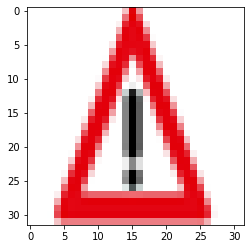

(1, 32, 32, 3)
danger (danger)


In [18]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import csv

labels = {}

with open('labelsIdent.csv', 'r') as f:
    lineas = f.read().splitlines()
    for l in lineas:
        par = l.split(',')
        labels[int(par[0])] = par[1]

def load_image(path, size):
    aux = imread(path)
    return resize(aux, size)

model = load_model('identTrafficSignals_batch50_VGG19.h5')
img = 'danger.jpg'
img = Image.open(img)
img = img.resize((32,32))
plt.imshow(img)
plt.show()

img = np.asarray(img, dtype = np.float32)
img = np.reshape(img, (1, 32, 32, 3))
img = img.astype('float32')
img /= 255
print(img.shape)
y = model.predict(img)
pred = list(y[0]).index(max(y[0]))

print(labels[pred])

In [14]:
!ls

30.jpg			    identTrafficSignals_batch50_VGG19.h5  x_train.npy
carretera_señales.jpg	    identTrafficSignals.ipynb		  y_test.npy
danger.jpg		    labels.csv				  y_train.npy
detectTrafficSignals.h5     stop.jpg				  zebra.jpg
detectTrafficSignals.ipynb  x_test.npy
